In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

# Seed

In [2]:
seed_number = 44

torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_number)
#random.seed(seed_number)

# MNIST data download

In [3]:
train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('./data/', train=False)

# Load dataset

In [4]:
X      = train_dataset.data
X_test = test_dataset.data

print(X.shape)
print(X_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [5]:
y      = train_dataset.targets
y_test = test_dataset.targets

print(y.shape)
print(y_test.shape)

torch.Size([60000])
torch.Size([10000])


In [6]:
print(y[10000])

tensor(3)


# One-hot vector

In [7]:
y = torch.nn.functional.one_hot(y, num_classes=10)
y_test = torch.nn.functional.one_hot(y_test, num_classes=10)

print(y.shape)
print(y_test.shape)

torch.Size([60000, 10])
torch.Size([10000, 10])


In [8]:
print(y[10000])

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


# Normalization

In [9]:
X = X / 255.
X_test = X_test / 255.

X = (X - 0.5) / 0.5
X_test = (X_test - 0.5) / 0.5

# Data loader

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

X = X.to(device=device)
X_test = X_test.to(device=device)

y = y.to(device=device)
y_test = y_test.to(device=device)

cpu


In [11]:
train_ds = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

# Model

In [12]:
class Generator(torch.nn.Module):
    def __init__(self, d_z, n_class):
        super(Generator, self).__init__()
        self.ConvT1 = torch.nn.ConvTranspose2d(d_z+n_class, 64, 4, 1, 0, bias=False)
        self.ConvT2 = torch.nn.ConvTranspose2d(64,  32, 4, 1, 0, bias=False)
        self.ConvT3 = torch.nn.ConvTranspose2d(32,  16, 4, 2, 1, bias=False)
        self.ConvT4 = torch.nn.ConvTranspose2d(16,   1, 4, 2, 1, bias=False)
        
    def forward(self, xb):        
        out = self.ConvT1(xb)
        out = torch.nn.BatchNorm2d(64)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.ConvT2(out)
        out = torch.nn.BatchNorm2d(32)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.ConvT3(out)
        out = torch.nn.BatchNorm2d(16)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.ConvT4(out)
        out = torch.nn.Tanh()(out)
        return out

In [13]:
class Discriminator(torch.nn.Module):
    def __init__(self, n_class):
        super(Discriminator, self).__init__()
        self.Conv1 = torch.nn.Conv2d(1,   8, 4, 2, 1, bias=False)
        self.Conv2 = torch.nn.Conv2d(8,  16, 4, 2, 1, bias=False)
        self.Conv3 = torch.nn.Conv2d(16, 32, 4, 1, 0, bias=False)
        self.Conv4 = torch.nn.Conv2d(32, 64, 4, 1, 0, bias=False)
        
        self.fully_connected_layer_1 = torch.nn.Linear(64+n_class, 32)
        self.fully_connected_layer_2 = torch.nn.Linear(32, 8)
        self.fully_connected_layer_3 = torch.nn.Linear(8,  1)
        
    def forward(self, xb, yb):
        out = self.Conv1(xb)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.Conv2(out)
        out = torch.nn.BatchNorm2d(16)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.Conv3(out)
        out = torch.nn.BatchNorm2d(32)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = self.Conv4(out)
        out = torch.nn.BatchNorm2d(64)(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        
        out = torch.cat([out.squeeze(-1).squeeze(-1), yb], dim=-1)
                
        out = self.fully_connected_layer_1(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        out = self.fully_connected_layer_2(out)
        out = torch.nn.LeakyReLU(0.2)(out)
        out = self.fully_connected_layer_3(out)
        out = torch.nn.Sigmoid()(out)
        return out

In [14]:
d_z = 64

Generator = Generator(d_z=d_z, n_class=10).to(device)
Discriminator = Discriminator(n_class=10).to(device)

print(Generator)
print(Discriminator)

Generator(
  (ConvT1): ConvTranspose2d(74, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (ConvT2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (ConvT3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ConvT4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (Conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (Conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (Conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (Conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fully_connected_layer_1): Linear(in_features=74, out_features=32, bias=True)
  (fully_connected_layer_2): Linear(in_features=32, out_features=8, bias=True)
  (fully_connected_layer_3): Linear(in_features=8, out_features=1, bias=True)
)


# Cost function

In [15]:
criterion = torch.nn.BCELoss()

# Optimizer

In [16]:
D_optimizer = torch.optim.Adam(Discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
G_optimizer = torch.optim.Adam(Generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

# Training

======== Epoch 1 =======
Loss     => G:1.11502, D:0.51505
Accuracy => G:5.67%, D:82.37%, Elapsed time => 55.537 sec

======== Epoch 2 =======
Loss     => G:1.85121, D:0.32381
Accuracy => G:9.28%, D:88.51%, Elapsed time => 56.752 sec

======== Epoch 3 =======
Loss     => G:2.15007, D:0.28765
Accuracy => G:9.45%, D:89.40%, Elapsed time => 56.962 sec

======== Epoch 4 =======
Loss     => G:2.29631, D:0.27760
Accuracy => G:9.93%, D:89.53%, Elapsed time => 54.635 sec

======== Epoch 5 =======
Loss     => G:2.36845, D:0.28006
Accuracy => G:10.52%, D:89.19%, Elapsed time => 54.491 sec


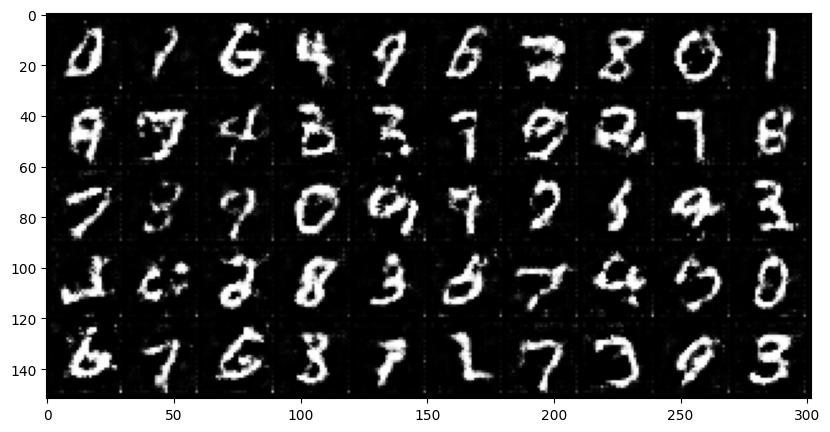


======== Epoch 6 =======
Loss     => G:2.43194, D:0.27141
Accuracy => G:10.31%, D:89.60%, Elapsed time => 54.632 sec

======== Epoch 7 =======
Loss     => G:2.52777, D:0.26205
Accuracy => G:10.36%, D:89.92%, Elapsed time => 54.517 sec

======== Epoch 8 =======
Loss     => G:2.64360, D:0.26353
Accuracy => G:10.01%, D:89.75%, Elapsed time => 54.419 sec

======== Epoch 9 =======
Loss     => G:2.64924, D:0.25425
Accuracy => G:10.16%, D:90.24%, Elapsed time => 55.582 sec

======== Epoch 10 =======
Loss     => G:2.73670, D:0.25262
Accuracy => G:9.75%, D:90.20%, Elapsed time => 54.964 sec


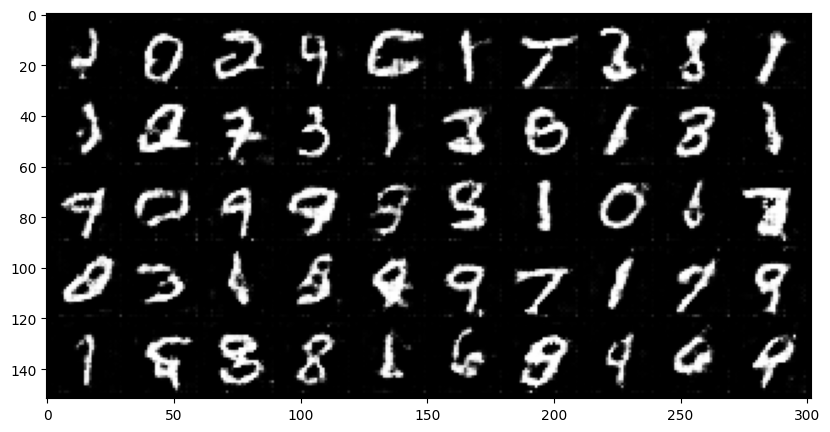


======== Epoch 11 =======
Loss     => G:2.68001, D:0.26003
Accuracy => G:10.61%, D:89.81%, Elapsed time => 55.019 sec

======== Epoch 12 =======
Loss     => G:2.52712, D:0.28628
Accuracy => G:11.61%, D:88.32%, Elapsed time => 53.641 sec

======== Epoch 13 =======
Loss     => G:2.33755, D:0.32820
Accuracy => G:13.08%, D:86.07%, Elapsed time => 53.503 sec

======== Epoch 14 =======
Loss     => G:2.20533, D:0.35019
Accuracy => G:14.24%, D:84.81%, Elapsed time => 53.788 sec

======== Epoch 15 =======
Loss     => G:2.08634, D:0.36536
Accuracy => G:15.45%, D:83.89%, Elapsed time => 53.635 sec


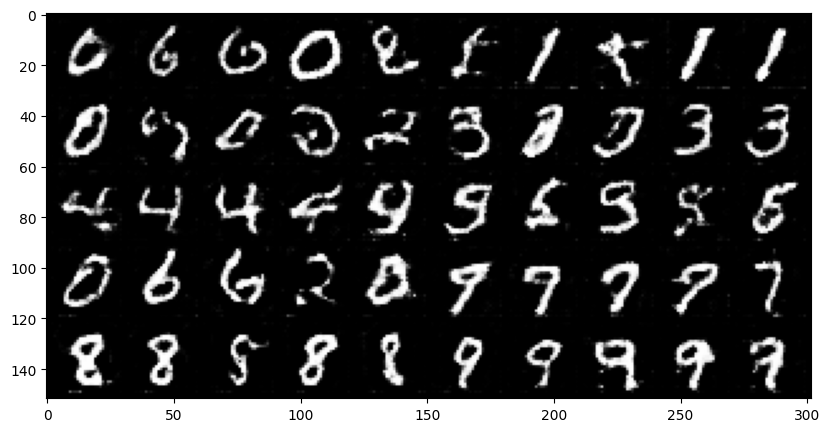


======== Epoch 16 =======
Loss     => G:1.99821, D:0.37538
Accuracy => G:16.07%, D:83.64%, Elapsed time => 53.821 sec

======== Epoch 17 =======
Loss     => G:1.95413, D:0.38584
Accuracy => G:16.20%, D:82.82%, Elapsed time => 53.703 sec

======== Epoch 18 =======
Loss     => G:1.92778, D:0.39232
Accuracy => G:17.11%, D:82.51%, Elapsed time => 53.233 sec

======== Epoch 19 =======
Loss     => G:1.88608, D:0.40674
Accuracy => G:16.96%, D:81.64%, Elapsed time => 51.833 sec

======== Epoch 20 =======
Loss     => G:1.85560, D:0.41951
Accuracy => G:17.82%, D:80.99%, Elapsed time => 45.793 sec


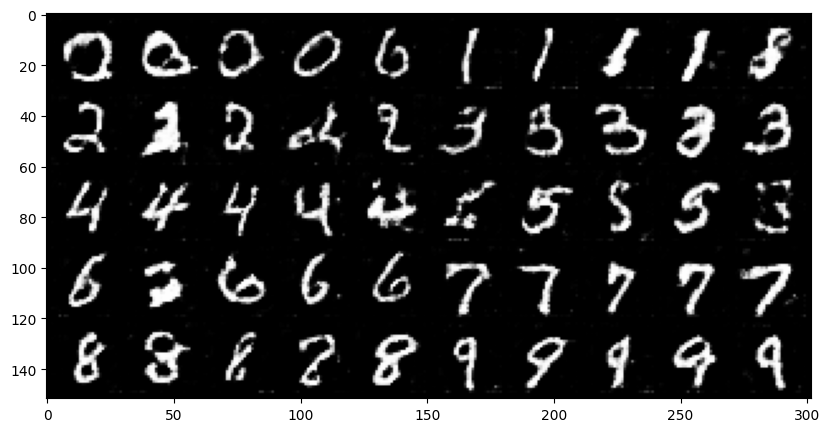


======== Epoch 21 =======
Loss     => G:1.77520, D:0.43253
Accuracy => G:18.71%, D:80.03%, Elapsed time => 45.735 sec

======== Epoch 22 =======
Loss     => G:1.70883, D:0.44910
Accuracy => G:19.55%, D:79.08%, Elapsed time => 45.376 sec

======== Epoch 23 =======
Loss     => G:1.65076, D:0.45895
Accuracy => G:20.62%, D:78.26%, Elapsed time => 45.464 sec

======== Epoch 24 =======
Loss     => G:1.62711, D:0.46466
Accuracy => G:20.56%, D:77.89%, Elapsed time => 46.137 sec

======== Epoch 25 =======
Loss     => G:1.61269, D:0.46636
Accuracy => G:20.47%, D:78.06%, Elapsed time => 45.549 sec


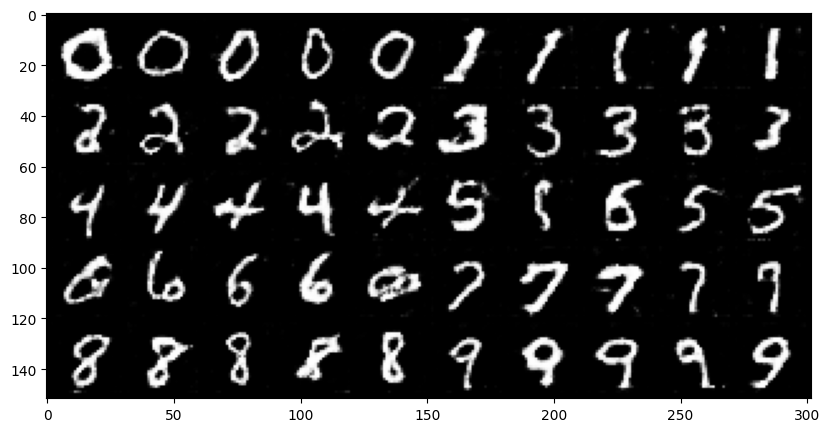


======== Epoch 26 =======
Loss     => G:1.57940, D:0.45733
Accuracy => G:21.28%, D:78.65%, Elapsed time => 45.168 sec

======== Epoch 27 =======
Loss     => G:1.58972, D:0.46606
Accuracy => G:20.48%, D:77.92%, Elapsed time => 45.283 sec

======== Epoch 28 =======
Loss     => G:1.61775, D:0.46353
Accuracy => G:19.72%, D:78.02%, Elapsed time => 45.847 sec

======== Epoch 29 =======
Loss     => G:1.60097, D:0.46188
Accuracy => G:20.07%, D:78.20%, Elapsed time => 45.092 sec

======== Epoch 30 =======
Loss     => G:1.59155, D:0.45938
Accuracy => G:20.75%, D:78.43%, Elapsed time => 44.452 sec


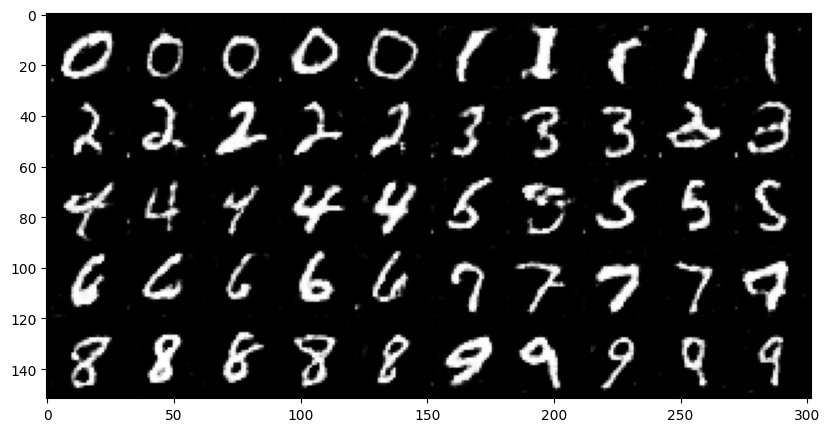


======== Epoch 31 =======
Loss     => G:1.60832, D:0.45634
Accuracy => G:20.09%, D:78.55%, Elapsed time => 44.900 sec

======== Epoch 32 =======
Loss     => G:1.60600, D:0.46292
Accuracy => G:20.37%, D:78.25%, Elapsed time => 44.657 sec

======== Epoch 33 =======
Loss     => G:1.60475, D:0.45339
Accuracy => G:20.26%, D:78.85%, Elapsed time => 44.929 sec

======== Epoch 34 =======
Loss     => G:1.63008, D:0.45523
Accuracy => G:19.76%, D:78.72%, Elapsed time => 44.731 sec

======== Epoch 35 =======
Loss     => G:1.61452, D:0.45917
Accuracy => G:20.08%, D:78.39%, Elapsed time => 44.669 sec


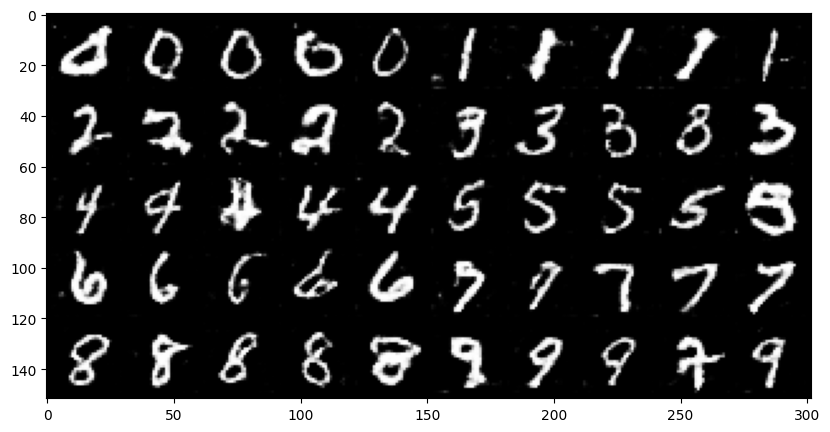


======== Epoch 36 =======
Loss     => G:1.65029, D:0.45479
Accuracy => G:19.86%, D:78.65%, Elapsed time => 44.770 sec

======== Epoch 37 =======
Loss     => G:1.63100, D:0.44649
Accuracy => G:20.13%, D:79.41%, Elapsed time => 44.684 sec

======== Epoch 38 =======
Loss     => G:1.63199, D:0.45551
Accuracy => G:20.15%, D:78.80%, Elapsed time => 43.257 sec

======== Epoch 39 =======
Loss     => G:1.60326, D:0.45524
Accuracy => G:20.36%, D:78.73%, Elapsed time => 41.720 sec

======== Epoch 40 =======
Loss     => G:1.62137, D:0.45249
Accuracy => G:20.53%, D:78.87%, Elapsed time => 41.615 sec


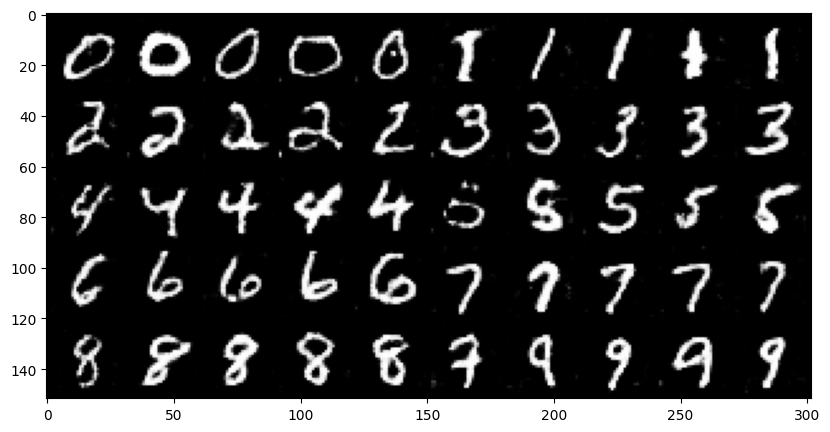


======== Epoch 41 =======
Loss     => G:1.65790, D:0.44511
Accuracy => G:19.32%, D:79.36%, Elapsed time => 40.057 sec

======== Epoch 42 =======
Loss     => G:1.66135, D:0.44548
Accuracy => G:19.14%, D:79.30%, Elapsed time => 40.686 sec

======== Epoch 43 =======
Loss     => G:1.69637, D:0.44176
Accuracy => G:18.90%, D:79.62%, Elapsed time => 40.547 sec

======== Epoch 44 =======
Loss     => G:1.68976, D:0.43540
Accuracy => G:19.06%, D:80.07%, Elapsed time => 40.683 sec

======== Epoch 45 =======
Loss     => G:1.68887, D:0.43904
Accuracy => G:19.65%, D:79.74%, Elapsed time => 40.468 sec


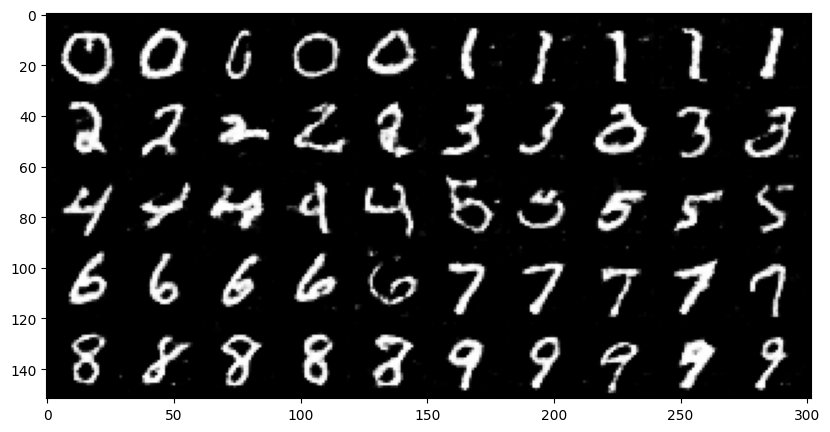


======== Epoch 46 =======
Loss     => G:1.70924, D:0.43179
Accuracy => G:18.82%, D:80.09%, Elapsed time => 40.212 sec

======== Epoch 47 =======
Loss     => G:1.76652, D:0.43387
Accuracy => G:17.72%, D:79.97%, Elapsed time => 40.368 sec

======== Epoch 48 =======
Loss     => G:1.76663, D:0.42825
Accuracy => G:17.80%, D:80.37%, Elapsed time => 40.400 sec

======== Epoch 49 =======
Loss     => G:1.76221, D:0.42359
Accuracy => G:18.66%, D:80.66%, Elapsed time => 40.316 sec

======== Epoch 50 =======
Loss     => G:1.81008, D:0.41521
Accuracy => G:17.85%, D:81.13%, Elapsed time => 40.317 sec


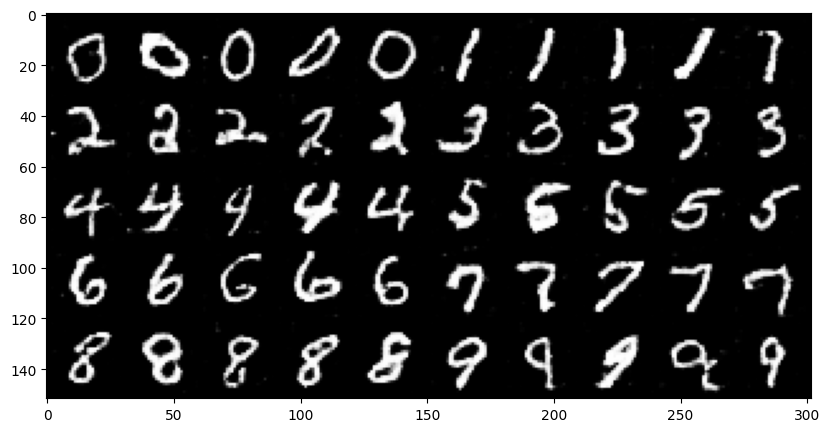


======== Epoch 51 =======
Loss     => G:1.82029, D:0.41258
Accuracy => G:17.31%, D:81.17%, Elapsed time => 40.162 sec

======== Epoch 52 =======
Loss     => G:1.80144, D:0.41621
Accuracy => G:18.19%, D:81.04%, Elapsed time => 40.000 sec

======== Epoch 53 =======
Loss     => G:1.85035, D:0.41067
Accuracy => G:17.24%, D:81.35%, Elapsed time => 40.082 sec

======== Epoch 54 =======
Loss     => G:1.84538, D:0.40054
Accuracy => G:17.45%, D:82.18%, Elapsed time => 40.102 sec

======== Epoch 55 =======
Loss     => G:1.86394, D:0.40803
Accuracy => G:17.94%, D:81.43%, Elapsed time => 40.184 sec


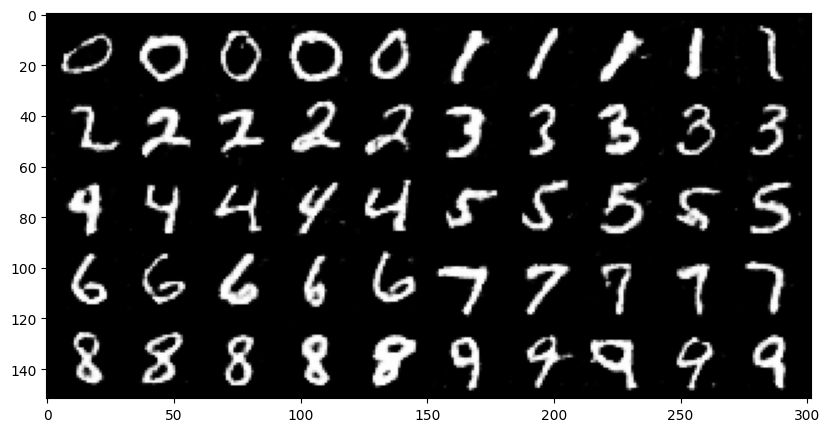


======== Epoch 56 =======
Loss     => G:1.87839, D:0.40873
Accuracy => G:17.46%, D:81.43%, Elapsed time => 39.998 sec

======== Epoch 57 =======
Loss     => G:1.90747, D:0.39862
Accuracy => G:16.64%, D:82.17%, Elapsed time => 40.233 sec

======== Epoch 58 =======
Loss     => G:1.89843, D:0.40735
Accuracy => G:17.42%, D:81.44%, Elapsed time => 40.295 sec

======== Epoch 59 =======
Loss     => G:1.91879, D:0.39642
Accuracy => G:17.01%, D:82.17%, Elapsed time => 40.210 sec

======== Epoch 60 =======
Loss     => G:1.95941, D:0.39468
Accuracy => G:16.15%, D:82.27%, Elapsed time => 40.179 sec


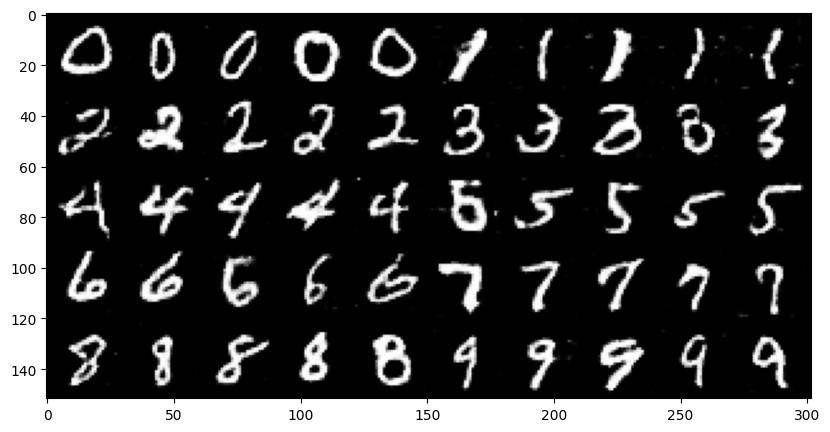


======== Epoch 61 =======
Loss     => G:1.91364, D:0.40036
Accuracy => G:16.99%, D:81.94%, Elapsed time => 40.424 sec

======== Epoch 62 =======
Loss     => G:1.99530, D:0.38479
Accuracy => G:15.96%, D:83.01%, Elapsed time => 40.441 sec

======== Epoch 63 =======
Loss     => G:1.97916, D:0.39000
Accuracy => G:16.75%, D:82.69%, Elapsed time => 40.495 sec

======== Epoch 64 =======
Loss     => G:1.97927, D:0.38853
Accuracy => G:16.35%, D:82.76%, Elapsed time => 40.500 sec

======== Epoch 65 =======
Loss     => G:2.00172, D:0.38282
Accuracy => G:15.68%, D:83.11%, Elapsed time => 40.513 sec


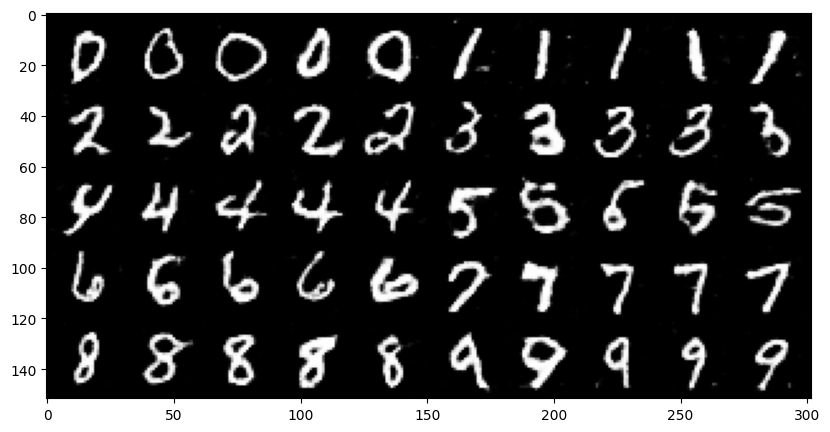


======== Epoch 66 =======
Loss     => G:2.00137, D:0.38180
Accuracy => G:16.34%, D:82.92%, Elapsed time => 40.458 sec

======== Epoch 67 =======
Loss     => G:2.03973, D:0.37360
Accuracy => G:15.80%, D:83.54%, Elapsed time => 40.288 sec

======== Epoch 68 =======
Loss     => G:2.04126, D:0.37689
Accuracy => G:16.10%, D:83.32%, Elapsed time => 40.364 sec

======== Epoch 69 =======
Loss     => G:2.05121, D:0.37584
Accuracy => G:15.56%, D:83.38%, Elapsed time => 40.334 sec

======== Epoch 70 =======
Loss     => G:2.09966, D:0.37155
Accuracy => G:15.53%, D:83.50%, Elapsed time => 40.530 sec


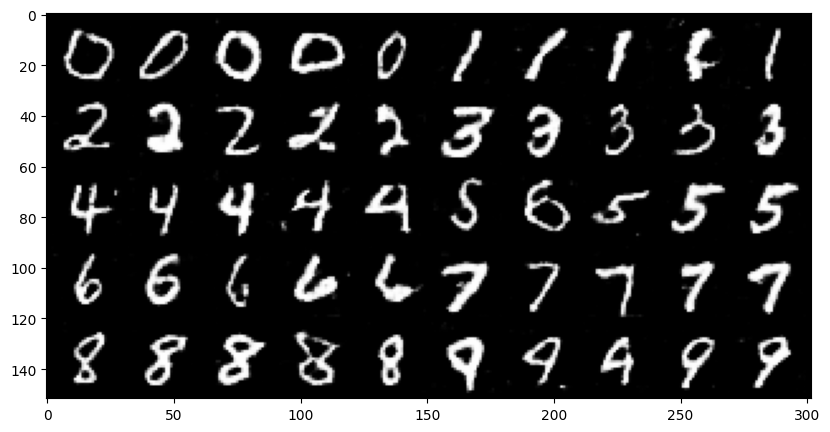


======== Epoch 71 =======
Loss     => G:2.09646, D:0.36645
Accuracy => G:15.49%, D:83.90%, Elapsed time => 40.947 sec

======== Epoch 72 =======
Loss     => G:2.10147, D:0.37581
Accuracy => G:15.63%, D:83.31%, Elapsed time => 40.690 sec

======== Epoch 73 =======
Loss     => G:2.11903, D:0.35982
Accuracy => G:15.30%, D:84.30%, Elapsed time => 40.827 sec

======== Epoch 74 =======
Loss     => G:2.14433, D:0.35600
Accuracy => G:14.96%, D:84.47%, Elapsed time => 40.600 sec

======== Epoch 75 =======
Loss     => G:2.14244, D:0.36454
Accuracy => G:15.15%, D:83.83%, Elapsed time => 40.701 sec


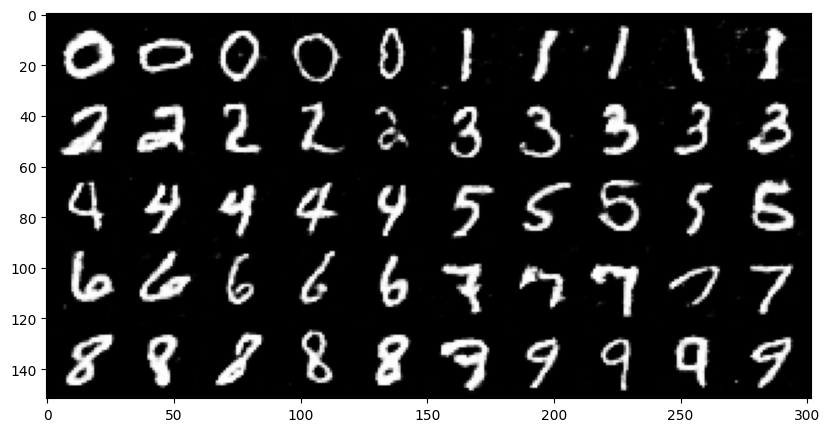


======== Epoch 76 =======
Loss     => G:2.15862, D:0.36457
Accuracy => G:15.53%, D:83.96%, Elapsed time => 40.937 sec

======== Epoch 77 =======
Loss     => G:2.18338, D:0.35332
Accuracy => G:14.36%, D:84.64%, Elapsed time => 40.830 sec

======== Epoch 78 =======
Loss     => G:2.17203, D:0.35790
Accuracy => G:15.08%, D:84.27%, Elapsed time => 40.976 sec

======== Epoch 79 =======
Loss     => G:2.18853, D:0.35123
Accuracy => G:15.21%, D:84.69%, Elapsed time => 40.801 sec

======== Epoch 80 =======
Loss     => G:2.16392, D:0.34997
Accuracy => G:15.47%, D:84.73%, Elapsed time => 40.886 sec


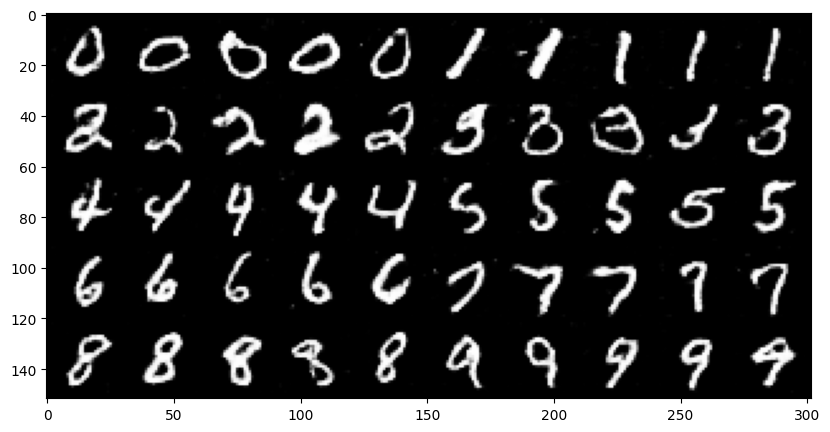


======== Epoch 81 =======
Loss     => G:2.28159, D:0.33901
Accuracy => G:13.95%, D:85.42%, Elapsed time => 40.397 sec

======== Epoch 82 =======
Loss     => G:2.24799, D:0.34053
Accuracy => G:13.84%, D:85.35%, Elapsed time => 40.657 sec

======== Epoch 83 =======
Loss     => G:2.23312, D:0.33794
Accuracy => G:14.60%, D:85.29%, Elapsed time => 40.910 sec

======== Epoch 84 =======
Loss     => G:2.28980, D:0.35393
Accuracy => G:14.79%, D:84.52%, Elapsed time => 40.648 sec

======== Epoch 85 =======
Loss     => G:2.29855, D:0.33287
Accuracy => G:14.17%, D:85.64%, Elapsed time => 40.185 sec


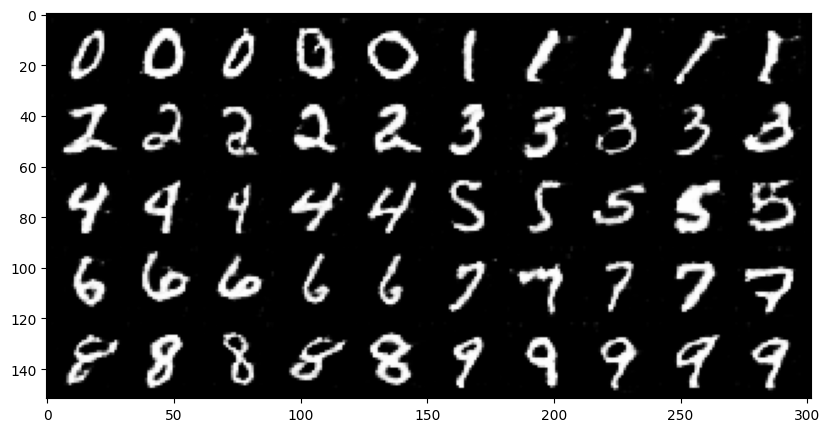


======== Epoch 86 =======
Loss     => G:2.31684, D:0.33461
Accuracy => G:13.88%, D:85.53%, Elapsed time => 40.181 sec

======== Epoch 87 =======
Loss     => G:2.37148, D:0.33857
Accuracy => G:13.44%, D:85.39%, Elapsed time => 40.344 sec

======== Epoch 88 =======
Loss     => G:2.31312, D:0.34037
Accuracy => G:14.04%, D:85.35%, Elapsed time => 40.323 sec

======== Epoch 89 =======
Loss     => G:2.30973, D:0.33554
Accuracy => G:13.77%, D:85.49%, Elapsed time => 40.383 sec

======== Epoch 90 =======
Loss     => G:2.37812, D:0.32878
Accuracy => G:13.48%, D:85.90%, Elapsed time => 40.367 sec


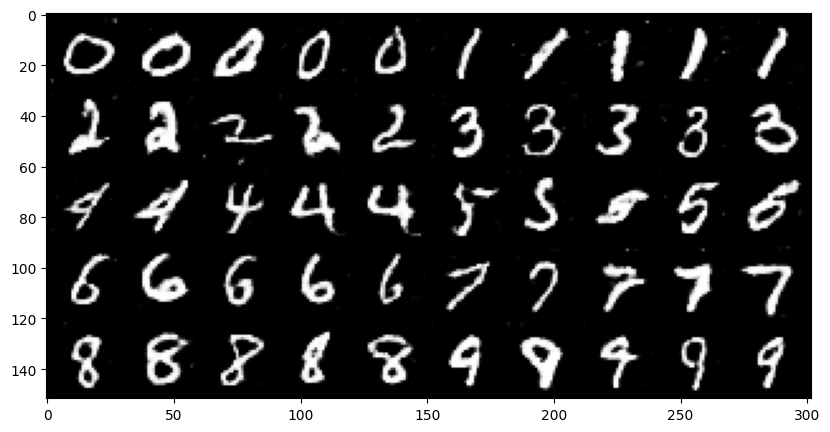


======== Epoch 91 =======
Loss     => G:2.37842, D:0.33451
Accuracy => G:13.88%, D:85.47%, Elapsed time => 40.266 sec

======== Epoch 92 =======
Loss     => G:2.38309, D:0.33352
Accuracy => G:13.90%, D:85.54%, Elapsed time => 40.450 sec

======== Epoch 93 =======
Loss     => G:2.37236, D:0.33337
Accuracy => G:14.19%, D:85.61%, Elapsed time => 40.874 sec

======== Epoch 94 =======
Loss     => G:2.45304, D:0.32559
Accuracy => G:12.70%, D:86.04%, Elapsed time => 40.943 sec

======== Epoch 95 =======
Loss     => G:2.45204, D:0.31729
Accuracy => G:12.91%, D:86.37%, Elapsed time => 41.117 sec


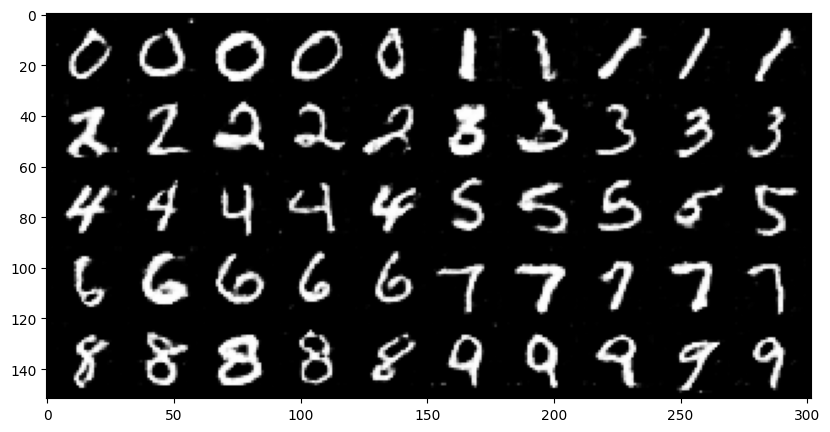


======== Epoch 96 =======
Loss     => G:2.47038, D:0.32834
Accuracy => G:12.72%, D:85.84%, Elapsed time => 41.363 sec

======== Epoch 97 =======
Loss     => G:2.42015, D:0.32282
Accuracy => G:13.00%, D:86.08%, Elapsed time => 40.967 sec

======== Epoch 98 =======
Loss     => G:2.44641, D:0.32059
Accuracy => G:13.28%, D:86.23%, Elapsed time => 40.474 sec

======== Epoch 99 =======
Loss     => G:2.50584, D:0.31755
Accuracy => G:12.83%, D:86.42%, Elapsed time => 40.426 sec

======== Epoch 100 =======
Loss     => G:2.52019, D:0.31545
Accuracy => G:12.28%, D:86.65%, Elapsed time => 40.351 sec


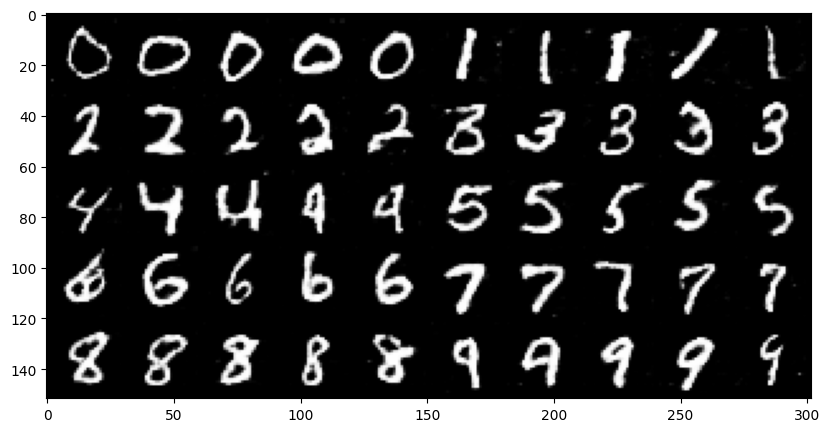


======== Epoch 101 =======
Loss     => G:2.47249, D:0.31504
Accuracy => G:13.43%, D:86.69%, Elapsed time => 40.304 sec

======== Epoch 102 =======
Loss     => G:2.49769, D:0.31110
Accuracy => G:13.21%, D:86.67%, Elapsed time => 40.410 sec

======== Epoch 103 =======
Loss     => G:2.48002, D:0.31368
Accuracy => G:13.01%, D:86.60%, Elapsed time => 40.417 sec

======== Epoch 104 =======
Loss     => G:2.52252, D:0.31543
Accuracy => G:12.74%, D:86.39%, Elapsed time => 40.467 sec

======== Epoch 105 =======
Loss     => G:2.52457, D:0.31220
Accuracy => G:12.96%, D:86.62%, Elapsed time => 40.433 sec


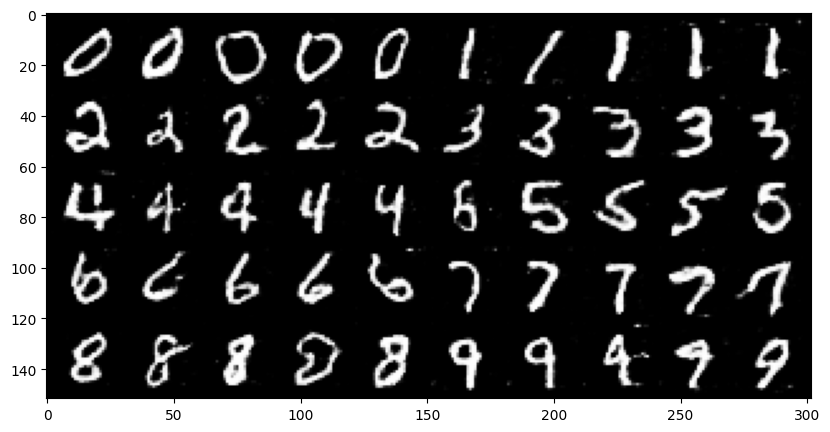


======== Epoch 106 =======
Loss     => G:2.58523, D:0.31259
Accuracy => G:12.16%, D:86.57%, Elapsed time => 40.437 sec

======== Epoch 107 =======
Loss     => G:2.54297, D:0.30593
Accuracy => G:12.91%, D:87.03%, Elapsed time => 40.483 sec

======== Epoch 108 =======
Loss     => G:2.58002, D:0.31103
Accuracy => G:12.47%, D:86.77%, Elapsed time => 40.200 sec

======== Epoch 109 =======
Loss     => G:2.56885, D:0.31239
Accuracy => G:12.45%, D:86.67%, Elapsed time => 40.183 sec

======== Epoch 110 =======
Loss     => G:2.56300, D:0.30884
Accuracy => G:12.03%, D:86.92%, Elapsed time => 40.407 sec


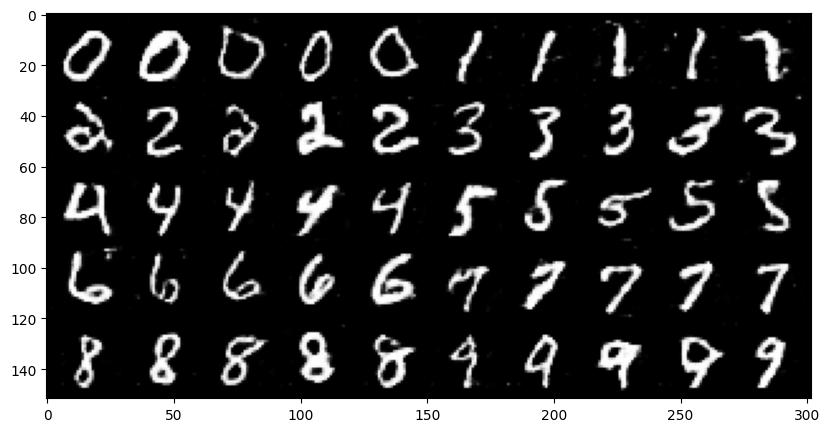


======== Epoch 111 =======
Loss     => G:2.57986, D:0.30798
Accuracy => G:13.05%, D:86.85%, Elapsed time => 40.284 sec

======== Epoch 112 =======
Loss     => G:2.60937, D:0.30437
Accuracy => G:12.32%, D:87.03%, Elapsed time => 40.766 sec

======== Epoch 113 =======
Loss     => G:2.67290, D:0.29141
Accuracy => G:11.80%, D:87.79%, Elapsed time => 40.797 sec

======== Epoch 114 =======
Loss     => G:2.62537, D:0.30643
Accuracy => G:12.52%, D:87.08%, Elapsed time => 40.926 sec

======== Epoch 115 =======
Loss     => G:2.66265, D:0.28300
Accuracy => G:11.91%, D:88.19%, Elapsed time => 41.027 sec


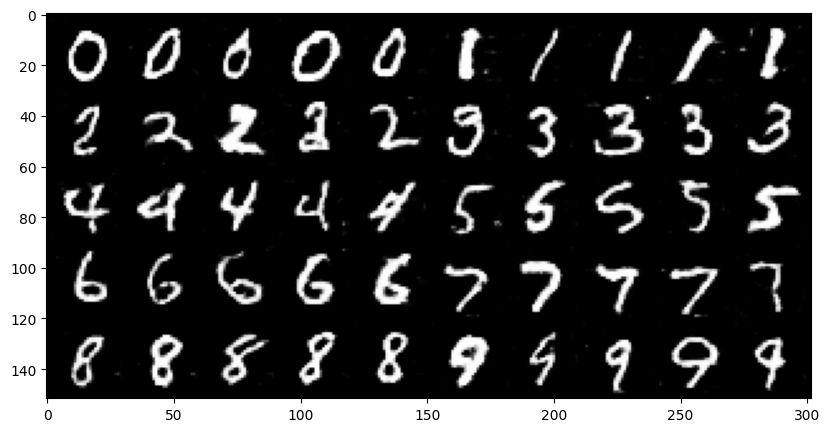


======== Epoch 116 =======
Loss     => G:2.70692, D:0.29546
Accuracy => G:11.78%, D:87.50%, Elapsed time => 40.461 sec

======== Epoch 117 =======
Loss     => G:2.70598, D:0.29099
Accuracy => G:11.88%, D:87.79%, Elapsed time => 40.432 sec

======== Epoch 118 =======
Loss     => G:2.69336, D:0.29139
Accuracy => G:11.62%, D:87.73%, Elapsed time => 40.575 sec

======== Epoch 119 =======
Loss     => G:2.67734, D:0.29362
Accuracy => G:12.14%, D:87.66%, Elapsed time => 40.527 sec

======== Epoch 120 =======
Loss     => G:2.72679, D:0.29083
Accuracy => G:11.40%, D:87.70%, Elapsed time => 40.523 sec


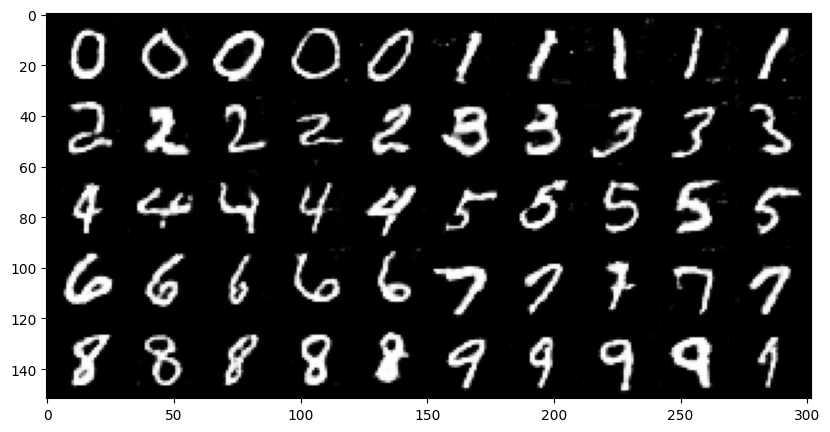


======== Epoch 121 =======
Loss     => G:2.74965, D:0.29326
Accuracy => G:11.56%, D:87.66%, Elapsed time => 40.251 sec

======== Epoch 122 =======
Loss     => G:2.70650, D:0.28762
Accuracy => G:12.15%, D:87.92%, Elapsed time => 40.211 sec

======== Epoch 123 =======
Loss     => G:2.77920, D:0.28356
Accuracy => G:11.25%, D:88.08%, Elapsed time => 40.717 sec

======== Epoch 124 =======
Loss     => G:2.83811, D:0.27660
Accuracy => G:10.59%, D:88.46%, Elapsed time => 40.768 sec

======== Epoch 125 =======
Loss     => G:2.81015, D:0.29444
Accuracy => G:11.27%, D:87.52%, Elapsed time => 40.882 sec


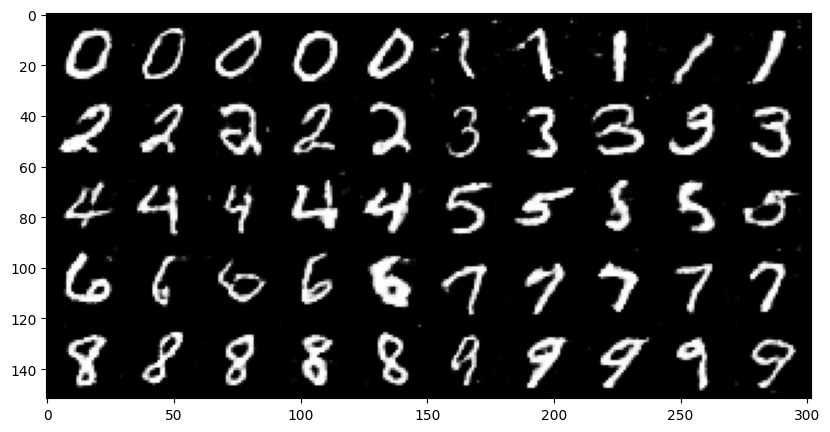


======== Epoch 126 =======
Loss     => G:2.85107, D:0.27589
Accuracy => G:10.49%, D:88.47%, Elapsed time => 40.707 sec

======== Epoch 127 =======
Loss     => G:2.84245, D:0.27610
Accuracy => G:10.73%, D:88.39%, Elapsed time => 40.490 sec

======== Epoch 128 =======
Loss     => G:2.90353, D:0.28170
Accuracy => G:10.98%, D:88.17%, Elapsed time => 40.110 sec

======== Epoch 129 =======
Loss     => G:2.89489, D:0.28127
Accuracy => G:10.49%, D:88.17%, Elapsed time => 40.100 sec

======== Epoch 130 =======
Loss     => G:2.85665, D:0.27498
Accuracy => G:11.29%, D:88.49%, Elapsed time => 40.200 sec


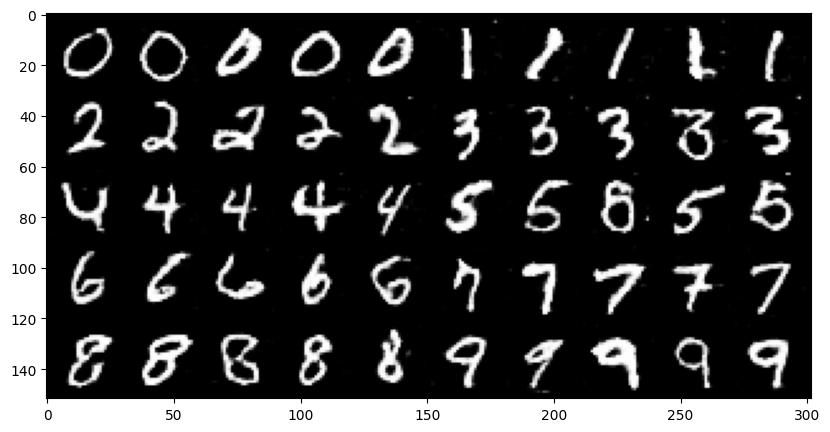


======== Epoch 131 =======
Loss     => G:2.86847, D:0.27129
Accuracy => G:10.67%, D:88.82%, Elapsed time => 41.261 sec

======== Epoch 132 =======
Loss     => G:2.87697, D:0.28127
Accuracy => G:11.72%, D:88.25%, Elapsed time => 40.099 sec

======== Epoch 133 =======
Loss     => G:2.88391, D:0.28365
Accuracy => G:10.96%, D:88.06%, Elapsed time => 40.167 sec

======== Epoch 134 =======
Loss     => G:2.97586, D:0.26903
Accuracy => G:10.06%, D:88.79%, Elapsed time => 40.090 sec

======== Epoch 135 =======
Loss     => G:2.93894, D:0.27127
Accuracy => G:10.35%, D:88.65%, Elapsed time => 40.127 sec


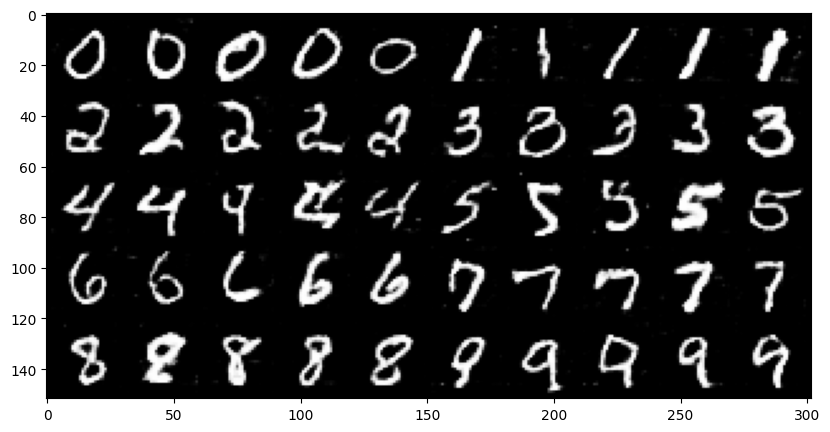


======== Epoch 136 =======
Loss     => G:2.93946, D:0.27415
Accuracy => G:10.83%, D:88.53%, Elapsed time => 41.083 sec

======== Epoch 137 =======
Loss     => G:2.95357, D:0.26797
Accuracy => G:10.35%, D:88.82%, Elapsed time => 40.263 sec

======== Epoch 138 =======
Loss     => G:3.01722, D:0.26756
Accuracy => G:10.09%, D:88.85%, Elapsed time => 40.303 sec

======== Epoch 139 =======
Loss     => G:2.98815, D:0.25749
Accuracy => G:10.12%, D:89.40%, Elapsed time => 40.171 sec

======== Epoch 140 =======
Loss     => G:2.99396, D:0.27051
Accuracy => G:10.78%, D:88.87%, Elapsed time => 40.224 sec


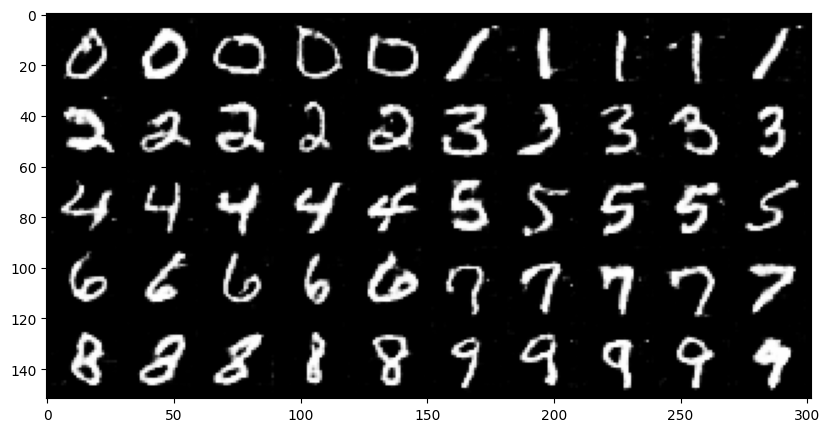


======== Epoch 141 =======
Loss     => G:3.08021, D:0.25947
Accuracy => G:9.64%, D:89.38%, Elapsed time => 40.679 sec

======== Epoch 142 =======
Loss     => G:3.00252, D:0.26515
Accuracy => G:10.53%, D:88.82%, Elapsed time => 40.531 sec

======== Epoch 143 =======
Loss     => G:2.99551, D:0.25620
Accuracy => G:10.39%, D:89.48%, Elapsed time => 40.445 sec

======== Epoch 144 =======
Loss     => G:3.07749, D:0.24876
Accuracy => G:9.85%, D:89.79%, Elapsed time => 40.460 sec

======== Epoch 145 =======
Loss     => G:3.08392, D:0.25678
Accuracy => G:10.20%, D:89.24%, Elapsed time => 40.465 sec


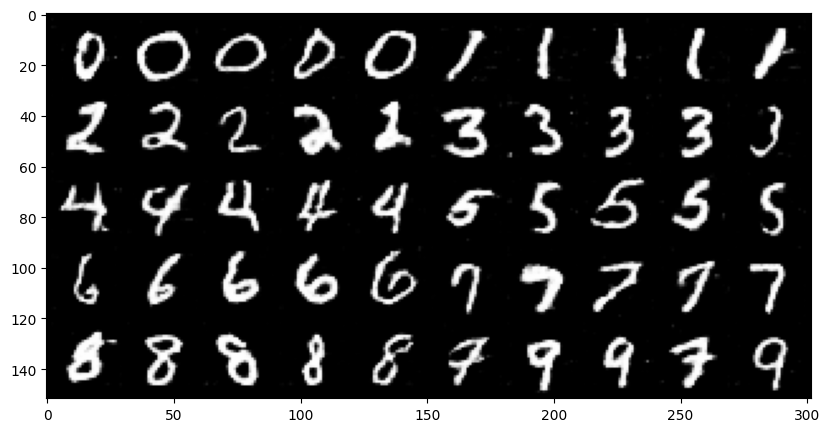


======== Epoch 146 =======
Loss     => G:3.11078, D:0.25436
Accuracy => G:9.62%, D:89.58%, Elapsed time => 40.442 sec

======== Epoch 147 =======
Loss     => G:3.09016, D:0.25307
Accuracy => G:10.02%, D:89.58%, Elapsed time => 40.350 sec

======== Epoch 148 =======
Loss     => G:3.04500, D:0.25882
Accuracy => G:11.02%, D:89.24%, Elapsed time => 40.408 sec

======== Epoch 149 =======
Loss     => G:3.10514, D:0.24695
Accuracy => G:10.16%, D:89.83%, Elapsed time => 40.442 sec

======== Epoch 150 =======
Loss     => G:3.13502, D:0.24661
Accuracy => G:9.40%, D:89.89%, Elapsed time => 40.377 sec


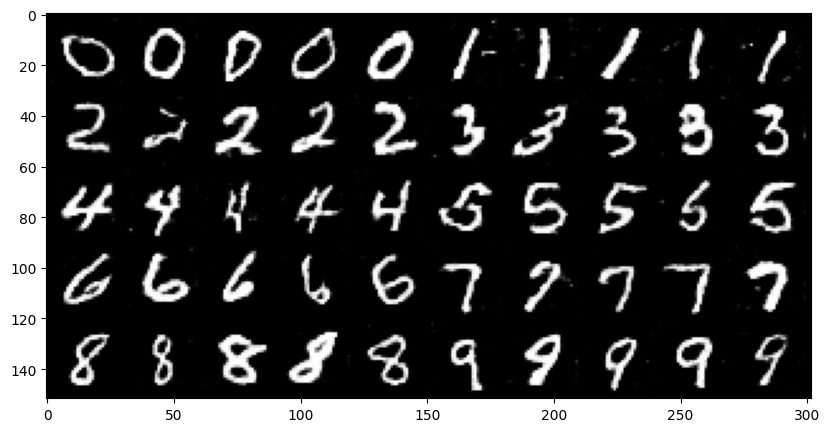


======== Epoch 151 =======
Loss     => G:3.19330, D:0.25019
Accuracy => G:10.18%, D:89.62%, Elapsed time => 40.658 sec

======== Epoch 152 =======
Loss     => G:3.16284, D:0.25477
Accuracy => G:10.30%, D:89.39%, Elapsed time => 40.743 sec

======== Epoch 153 =======
Loss     => G:3.22839, D:0.25780
Accuracy => G:9.79%, D:89.29%, Elapsed time => 40.815 sec

======== Epoch 154 =======
Loss     => G:3.19070, D:0.25158
Accuracy => G:9.94%, D:89.60%, Elapsed time => 40.868 sec

======== Epoch 155 =======
Loss     => G:3.19181, D:0.24681
Accuracy => G:9.50%, D:89.90%, Elapsed time => 40.750 sec


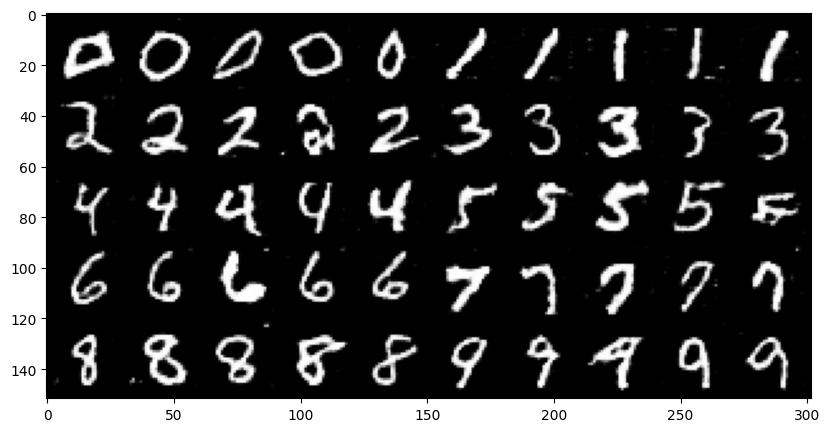


======== Epoch 156 =======
Loss     => G:3.18610, D:0.23930
Accuracy => G:9.61%, D:90.18%, Elapsed time => 40.411 sec

======== Epoch 157 =======
Loss     => G:3.21323, D:0.24903
Accuracy => G:10.37%, D:89.81%, Elapsed time => 41.899 sec

======== Epoch 158 =======
Loss     => G:3.27767, D:0.23970
Accuracy => G:9.49%, D:90.18%, Elapsed time => 40.450 sec

======== Epoch 159 =======
Loss     => G:3.24124, D:0.24553
Accuracy => G:9.72%, D:89.88%, Elapsed time => 40.723 sec

======== Epoch 160 =======
Loss     => G:3.34007, D:0.23904
Accuracy => G:8.74%, D:90.21%, Elapsed time => 40.650 sec


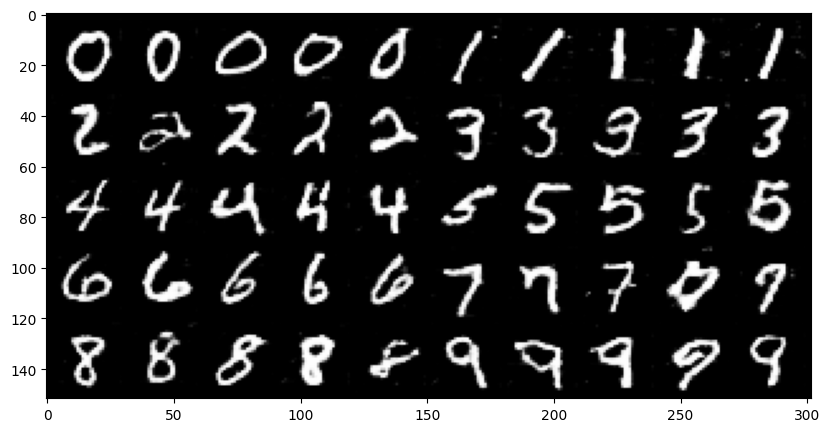


======== Epoch 161 =======
Loss     => G:3.31210, D:0.23603
Accuracy => G:8.94%, D:90.31%, Elapsed time => 40.867 sec

======== Epoch 162 =======
Loss     => G:3.29753, D:0.24429
Accuracy => G:9.57%, D:89.91%, Elapsed time => 40.340 sec

======== Epoch 163 =======
Loss     => G:3.34997, D:0.24386
Accuracy => G:8.70%, D:89.97%, Elapsed time => 40.626 sec

======== Epoch 164 =======
Loss     => G:3.34754, D:0.23760
Accuracy => G:8.68%, D:90.31%, Elapsed time => 40.550 sec

======== Epoch 165 =======
Loss     => G:3.37381, D:0.23372
Accuracy => G:9.17%, D:90.50%, Elapsed time => 40.656 sec


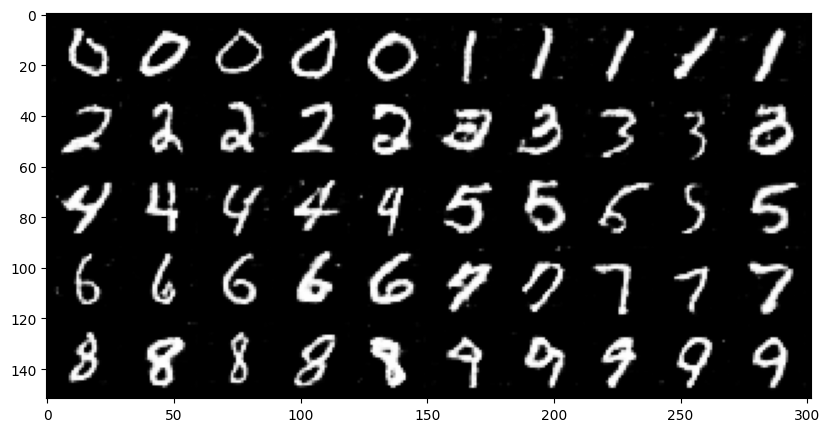


======== Epoch 166 =======
Loss     => G:3.40413, D:0.23429
Accuracy => G:8.94%, D:90.40%, Elapsed time => 40.525 sec

======== Epoch 167 =======
Loss     => G:3.33881, D:0.22763
Accuracy => G:9.24%, D:90.75%, Elapsed time => 40.167 sec

======== Epoch 168 =======
Loss     => G:3.39681, D:0.22505
Accuracy => G:8.74%, D:90.87%, Elapsed time => 40.183 sec

======== Epoch 169 =======
Loss     => G:3.36436, D:0.23378
Accuracy => G:9.34%, D:90.54%, Elapsed time => 40.317 sec

======== Epoch 170 =======
Loss     => G:3.46103, D:0.22400
Accuracy => G:8.41%, D:90.83%, Elapsed time => 40.132 sec


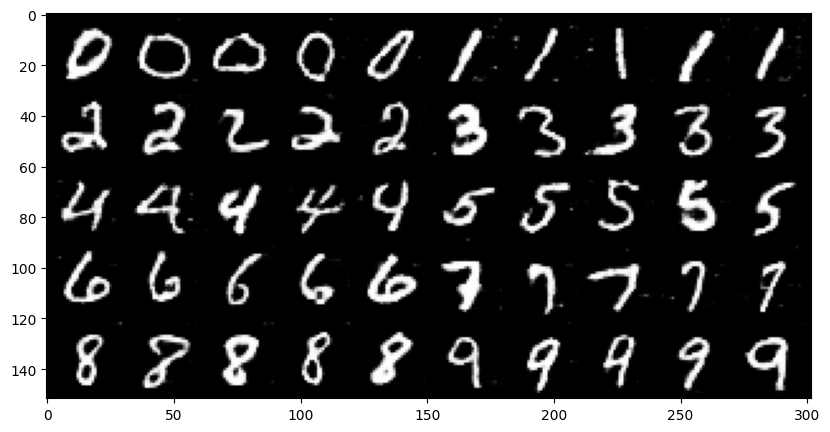


======== Epoch 171 =======
Loss     => G:3.44519, D:0.23231
Accuracy => G:9.45%, D:90.52%, Elapsed time => 39.906 sec

======== Epoch 172 =======
Loss     => G:3.40150, D:0.22343
Accuracy => G:8.86%, D:90.92%, Elapsed time => 40.000 sec

======== Epoch 173 =======
Loss     => G:3.50397, D:0.22687
Accuracy => G:8.72%, D:90.72%, Elapsed time => 39.936 sec

======== Epoch 174 =======
Loss     => G:3.55693, D:0.22041
Accuracy => G:8.41%, D:91.07%, Elapsed time => 39.821 sec

======== Epoch 175 =======
Loss     => G:3.47953, D:0.23136
Accuracy => G:9.40%, D:90.61%, Elapsed time => 39.943 sec


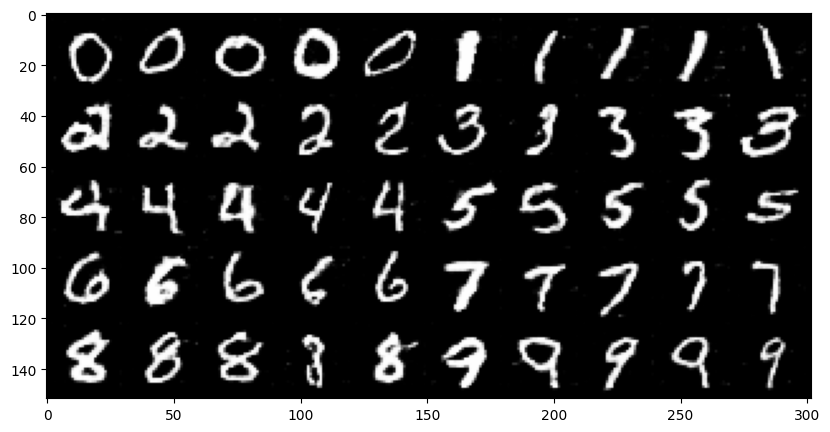


======== Epoch 176 =======
Loss     => G:3.43897, D:0.21808
Accuracy => G:9.28%, D:91.25%, Elapsed time => 40.062 sec

======== Epoch 177 =======
Loss     => G:3.55391, D:0.23200
Accuracy => G:8.75%, D:90.53%, Elapsed time => 39.905 sec

======== Epoch 178 =======
Loss     => G:3.56952, D:0.22603
Accuracy => G:8.88%, D:90.75%, Elapsed time => 40.115 sec

======== Epoch 179 =======
Loss     => G:3.51210, D:0.21999
Accuracy => G:8.60%, D:91.10%, Elapsed time => 39.927 sec

======== Epoch 180 =======
Loss     => G:3.64248, D:0.22745
Accuracy => G:8.10%, D:90.82%, Elapsed time => 39.968 sec


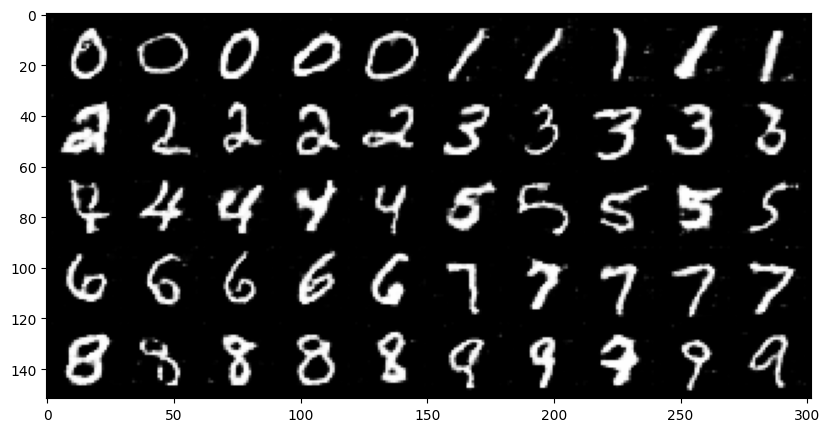


======== Epoch 181 =======
Loss     => G:3.44981, D:0.23222
Accuracy => G:9.40%, D:90.51%, Elapsed time => 39.956 sec

======== Epoch 182 =======
Loss     => G:3.54449, D:0.21689
Accuracy => G:9.08%, D:91.24%, Elapsed time => 40.667 sec

======== Epoch 183 =======
Loss     => G:3.63158, D:0.21767
Accuracy => G:8.03%, D:91.20%, Elapsed time => 40.967 sec

======== Epoch 184 =======
Loss     => G:3.50866, D:0.22402
Accuracy => G:9.06%, D:90.82%, Elapsed time => 40.888 sec

======== Epoch 185 =======
Loss     => G:3.53699, D:0.21663
Accuracy => G:8.28%, D:91.26%, Elapsed time => 40.764 sec


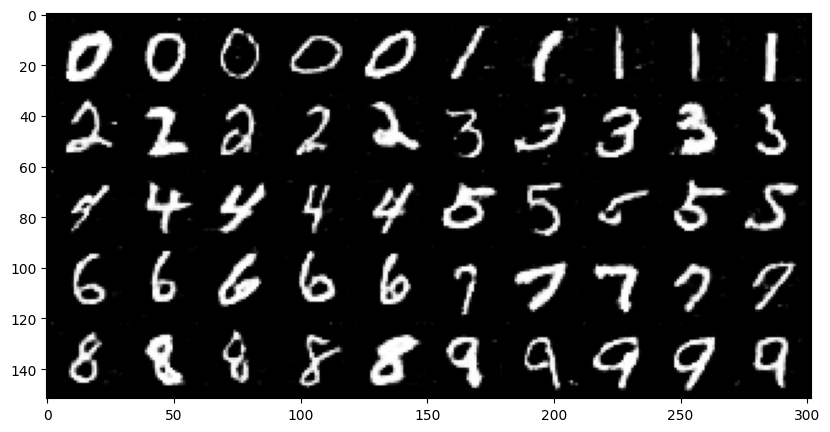


======== Epoch 186 =======
Loss     => G:3.67498, D:0.20943
Accuracy => G:8.05%, D:91.52%, Elapsed time => 40.794 sec

======== Epoch 187 =======
Loss     => G:3.67645, D:0.21505
Accuracy => G:8.43%, D:91.36%, Elapsed time => 40.819 sec

======== Epoch 188 =======
Loss     => G:3.63096, D:0.20735
Accuracy => G:8.27%, D:91.64%, Elapsed time => 40.689 sec

======== Epoch 189 =======
Loss     => G:3.62814, D:0.21623
Accuracy => G:8.72%, D:91.23%, Elapsed time => 40.700 sec

======== Epoch 190 =======
Loss     => G:3.78855, D:0.21348
Accuracy => G:7.99%, D:91.35%, Elapsed time => 40.826 sec


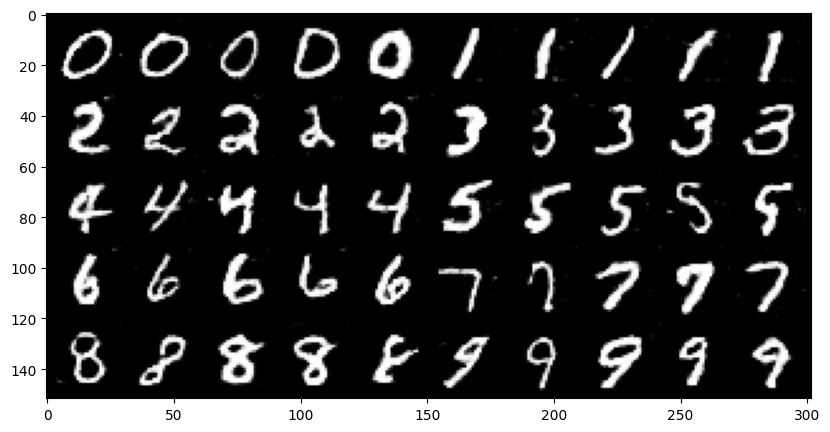


======== Epoch 191 =======
Loss     => G:3.65605, D:0.21669
Accuracy => G:8.64%, D:91.18%, Elapsed time => 40.645 sec

======== Epoch 192 =======
Loss     => G:3.73118, D:0.22121
Accuracy => G:8.06%, D:90.98%, Elapsed time => 40.556 sec

======== Epoch 193 =======
Loss     => G:3.70362, D:0.21528
Accuracy => G:8.31%, D:91.40%, Elapsed time => 40.562 sec

======== Epoch 194 =======
Loss     => G:3.69171, D:0.21449
Accuracy => G:8.19%, D:91.35%, Elapsed time => 40.766 sec

======== Epoch 195 =======
Loss     => G:3.73993, D:0.20859
Accuracy => G:8.06%, D:91.55%, Elapsed time => 40.571 sec


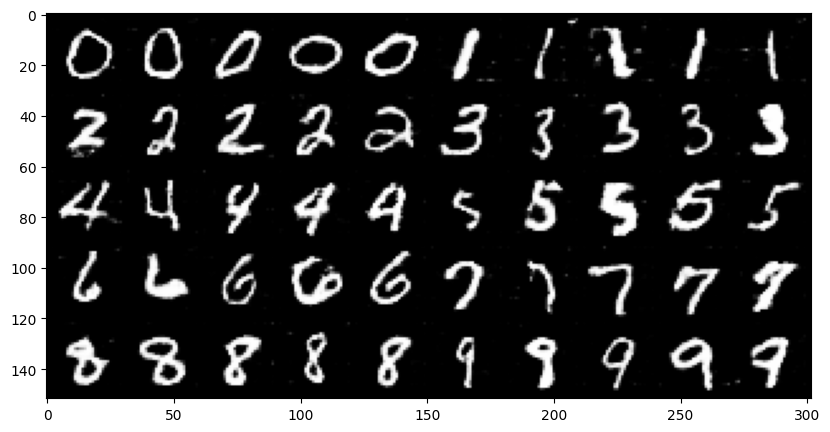


======== Epoch 196 =======
Loss     => G:3.67480, D:0.21242
Accuracy => G:8.80%, D:91.36%, Elapsed time => 40.330 sec

======== Epoch 197 =======
Loss     => G:3.73647, D:0.21063
Accuracy => G:8.34%, D:91.54%, Elapsed time => 40.332 sec

======== Epoch 198 =======
Loss     => G:3.79212, D:0.21594
Accuracy => G:8.14%, D:91.25%, Elapsed time => 40.285 sec

======== Epoch 199 =======
Loss     => G:3.75713, D:0.20776
Accuracy => G:7.80%, D:91.64%, Elapsed time => 40.467 sec

======== Epoch 200 =======
Loss     => G:3.72950, D:0.20992
Accuracy => G:8.23%, D:91.54%, Elapsed time => 40.267 sec


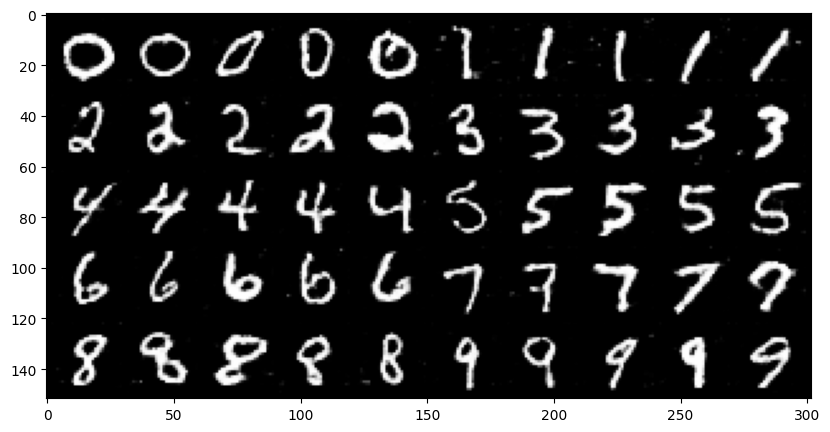

In [17]:
import time 

for epoch in range(200):
    start = time.time()
    D_train_loss, D_accuracy, D_count = 0., 0., 0.
    G_train_loss, G_accuracy, G_count = 0., 0., 0.
    
    for xb, yb in train_loader:
        
        ### train Discriminator
        real_x = xb.unsqueeze(1)
        real_y = torch.ones(len(xb), 1).to(device)
        D_out = Discriminator(real_x, yb)
        D_real_loss = criterion(D_out, real_y)
        D_accuracy += (D_out>0.5).float().eq(real_y.data).sum()
                
        z = torch.randn(len(xb), d_z).to(device)
        z_c = torch.cat([z, yb], dim=-1).unsqueeze(-1).unsqueeze(-1)
        fake_x = Generator(z_c)
        fake_y = torch.zeros(len(xb), 1).to(device)
        D_out = Discriminator(fake_x, yb)
        D_fake_loss = criterion(D_out, fake_y)
        D_accuracy += (D_out>0.5).float().eq(fake_y.data).sum()
        
        D_loss = D_real_loss + D_fake_loss
        D_train_loss += D_loss.item()*len(xb)
        D_count += len(xb)*2
        
        D_loss.backward()
        D_optimizer.step()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        
        ### train Generator
        z = torch.randn(len(xb), d_z).to(device)
        z_c = torch.cat([z, yb], dim=-1).unsqueeze(-1).unsqueeze(-1)
        fake_x = Generator(z_c)
        fake_y = torch.ones(len(xb), 1).to(device)
        D_out = Discriminator(fake_x, yb)
        G_loss = criterion(D_out, fake_y)
        G_accuracy += (D_out>0.5).float().eq(fake_y.data).sum()
        
        G_train_loss += G_loss.item()*len(xb)
        G_count += len(xb)
        
        G_loss.backward()
        G_optimizer.step()
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()
    
       
    D_train_loss /= D_count
    G_train_loss /= G_count
    D_accuracy   /= D_count
    G_accuracy   /= G_count
            
    print(f"======== Epoch {epoch+1} =======")
    print(f"Loss     => G:{G_train_loss:.5f}, D:{D_train_loss:.5f}")
    print(f"Accuracy => G:{G_accuracy*100:.2f}%, D:{D_accuracy*100:.2f}%, Elapsed time => {time.time()-start:.3f} sec")
    
     ### visualize progress
    if (epoch+1)%5 == 0:
        n_test = 5
        results = []
        for c in range(10):
            one_hot_test = torch.zeros(n_test, 10)
            one_hot_test[:,c] = 1
        
            z = torch.randn(n_test, d_z).to(device)
            z_c = torch.cat([z, one_hot_test], dim=-1).unsqueeze(-1).unsqueeze(-1)
            output = Generator(z_c)
            results.append(output)
        
        results = torch.cat(results, dim=0)
        generated_img = torchvision.utils.make_grid(results.view(-1,1,28,28), nrow=10, normalize=True)
        plt.figure(figsize=(20,5))
        plt.imshow(np.transpose(generated_img.numpy(),(1,2,0)))
        plt.show()
        
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()
    print("=======================================\n")